# Подключим библиотеки

In [ ]:
!pip install pmdarima -q
# sktime -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd

import numpy as np

from sklearn.preprocessing import MinMaxScaler


from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_absolute_percentage_error as MAPE
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error as MSE

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

from scipy.stats import norm

from prophet import Prophet



# from sktime.forecasting.model_selection import temporal_train_test_split
# from sktime.performance_metrics.forecasting import smape_loss



import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (23,9)

## SARIMA

#Отсюда начинается работа с моим датасетом
Температура в Москве за 1975-2023 год

https://drive.google.com/file/d/1coG3Daxocpe2G6-2Mvsz1v3oRzo_B8cq/view?usp=sharing

In [ ]:
# чтение датасета в pandas
!gdown 1coG3Daxocpe2G6-2Mvsz1v3oRzo_B8cq
data = pd.read_csv('moscow_1975_2023_ok.csv')
data.head()

,date,temperature
0,1975-01-01,-5.0
1,1975-01-02,-6.1
2,1975-01-03,-3.0
3,1975-01-04,0.8
4,1975-01-05,-1.0


In [ ]:
# Выберем строки, где дата больше или равна 1 января 2018 года
data = data[data['date'] >= '2018-01-01']

# Переиндексируем новый датафрейм
data = data.reset_index(drop=True)

In [ ]:
data

,date,temperature
0,2018-01-01,0.30
1,2018-01-02,1.40
2,2018-01-03,2.10
3,2018-01-04,1.40
4,2018-01-05,-1.30
...,...,...
2135,2023-11-06,7.79
2136,2023-11-07,6.97
2137,2023-11-08,5.51
2138,2023-11-09,3.62


In [ ]:
# Преобразование столбца с датой в объект datetime и установка его в качестве индекса
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

In [ ]:
# Меняем названия столбцов
data.rename(columns={'date': 'date',
                   'temperature': 'y'},
          inplace=True)

In [ ]:
data

,y
date,
2018-01-01,0.30
2018-01-02,1.40
2018-01-03,2.10
2018-01-04,1.40
2018-01-05,-1.30
...,...
2023-11-06,7.79
2023-11-07,6.97
2023-11-08,5.51


#График температуры в Москве за 2018 - 2023гг.

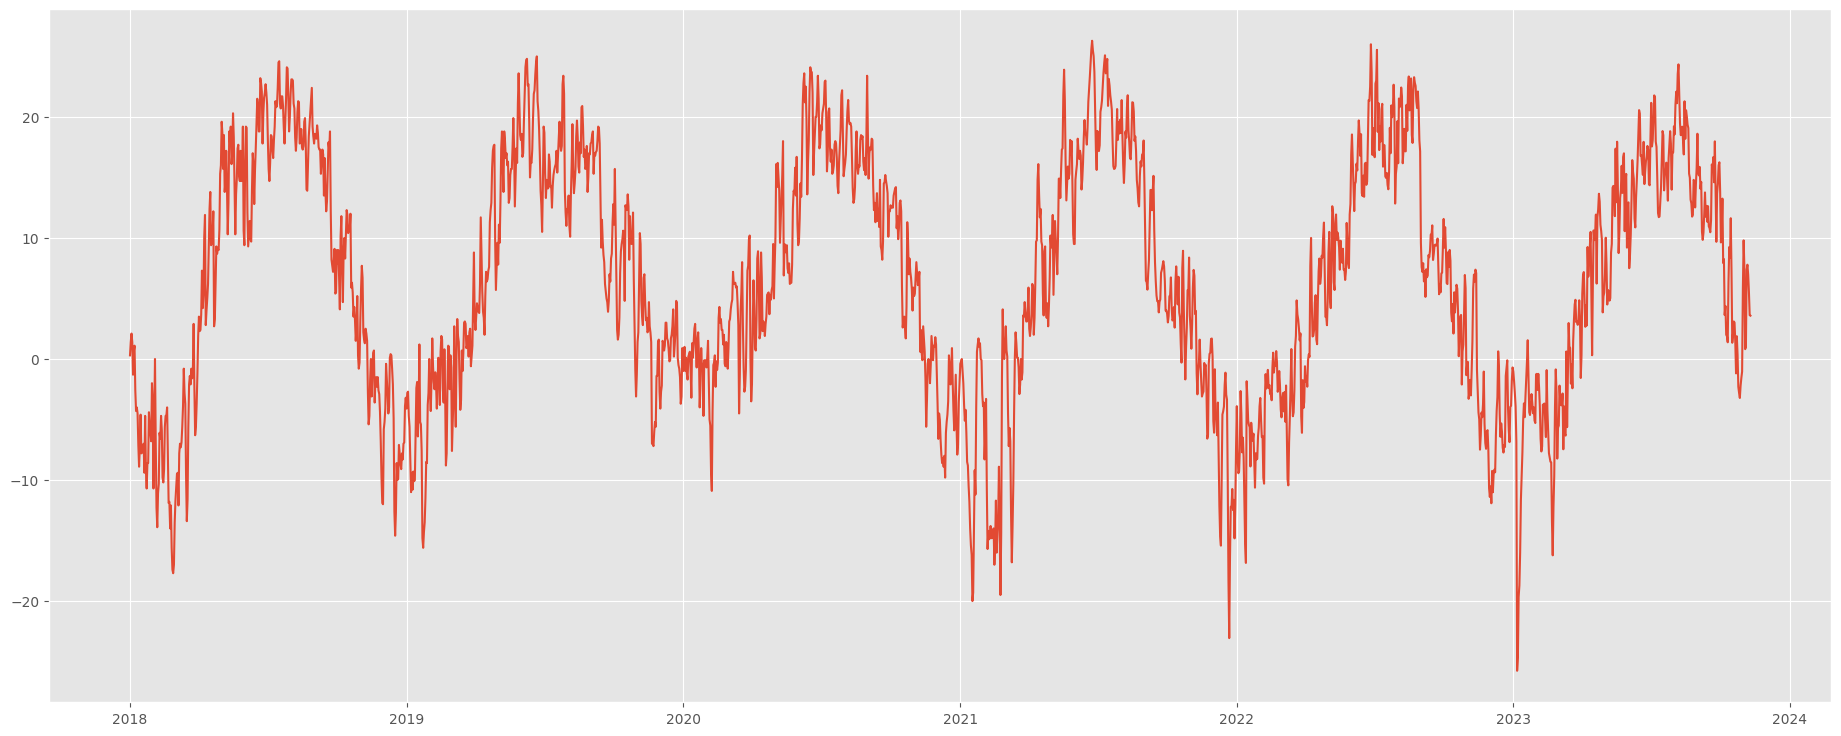

In [ ]:
plt.plot(data['y'])

In [ ]:

# Проверяем стационарность с помощью теста Дики-Фуллера
result = adfuller(data['y'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])


ADF Statistic: -2.807845801228309
p-value: 0.057161761491324285
Critical Values: {'1%': -3.4334310432399135, '5%': -2.8629010829823898, '10%': -2.5674945750034603}


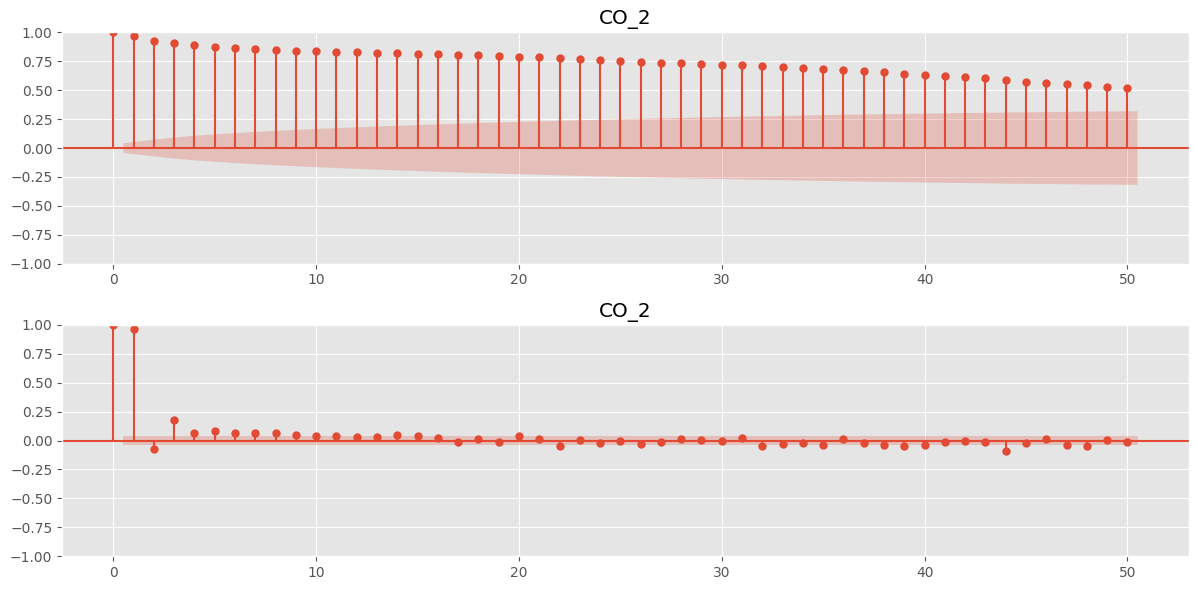

In [ ]:

# Построение PACF и ACF
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(data['y'], lags=50, ax=plt.gca(), title='CO_2')
plt.subplot(2, 1, 2)
plot_pacf(data['y'], lags=50, ax=plt.gca(), title='CO_2')
plt.tight_layout()
plt.show()


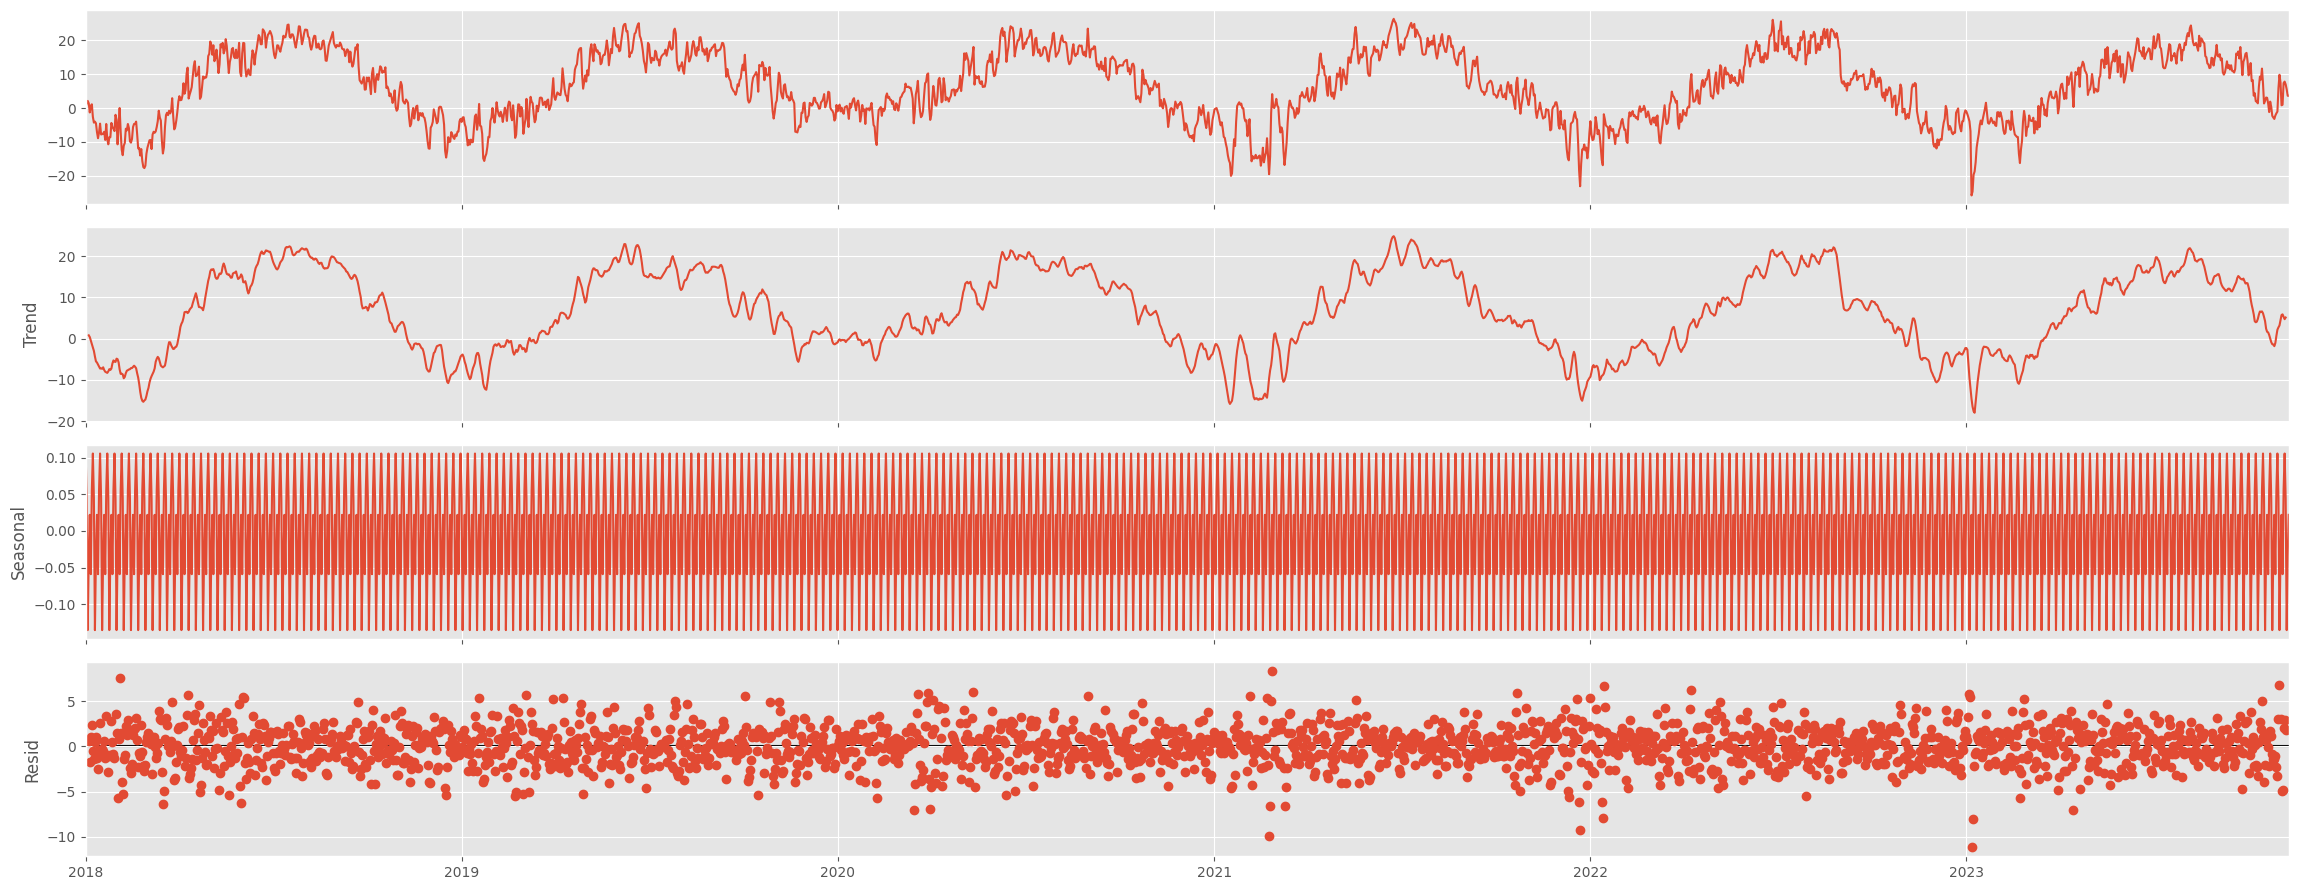

In [ ]:
fig = seasonal_decompose(data).plot()

In [ ]:
auto_arima(data).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2140
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -4978.368
Date:                Sat, 18 Nov 2023   AIC                           9968.736
Time:                        10:50:27   BIC                          10002.747
Sample:                    01-01-2018   HQIC                          9981.182
                         - 11-10-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0167      0.011      1.477      0.140      -0.005       0.039
ar.L1          1.5875      0.043     36.899      0.000       1.503       1.672
ar.L2         -0.5903      0.042    -13.909      0.000      -0.673      -0.507
ma.L1         -0.5747      0.044    -12.961      0.000      -0.662      -0.488
ma.L2         -0.2466      0.022    -10.968      0.000      -0.291      -0.203
sigma2         6.1312      0.127     48.237      0.000       5.882       6.380
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               651.14
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.19   Skew:                            -0.34
Prob(H) (two-sided):                  0.02   Kurtosis:                         5.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#Делим на тренировочную и тестовую выборки

In [ ]:
train = data[:-90]
test = data[-90:]

In [ ]:
test

,y
date,
2023-08-13,18.08
2023-08-14,16.90
2023-08-15,21.29
2023-08-16,18.19
2023-08-17,20.55
...,...
2023-11-06,7.79
2023-11-07,6.97
2023-11-08,5.51


#Пытаемся настроить модель SARIMA

In [ ]:
# Настройка модели SARIMA
order = (2, 1, 1)  # порядок авторегрессии, разности и скользящего среднего
seasonal_order = (1, 1, 1, 365)  # порядок сезонной авторегрессии, разности и скользящего среднего, и период сезонности

# Обучение модели
model = sm.tsa.statespace.SARIMAX(train, order=order, seasonal_order=seasonal_order)
st_model = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


#Обучение модели

In [ ]:
#st_model = SARIMAX(train, order=(2, 1, 1)).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [ ]:
st_prediction = st_model.forecast(90)

In [ ]:
test.join(st_prediction)

,y,predicted_mean
date,,
2023-10-30,-1.04,-1.045795
2023-10-31,5.82,-0.797328
2023-11-01,9.80,-0.566794
2023-11-02,7.51,-0.386429
2023-11-03,0.81,-0.333938
2023-11-04,0.99,-0.415835
2023-11-05,7.36,-0.372023
2023-11-06,7.79,-0.406312
2023-11-07,6.97,-0.387867


#Оценка качества модели

In [ ]:
mse = MSE(test, st_prediction)
print('MAPE:', MAPE(test, st_prediction))
print('RMSE:', mse**.5)
print('MSE:', mse)

MAPE: 1.0409304533366914
RMSE: 6.213832939302955
MSE: 38.61171979756641


#ARIMA. Сравнение тестовой выборки и предсказания

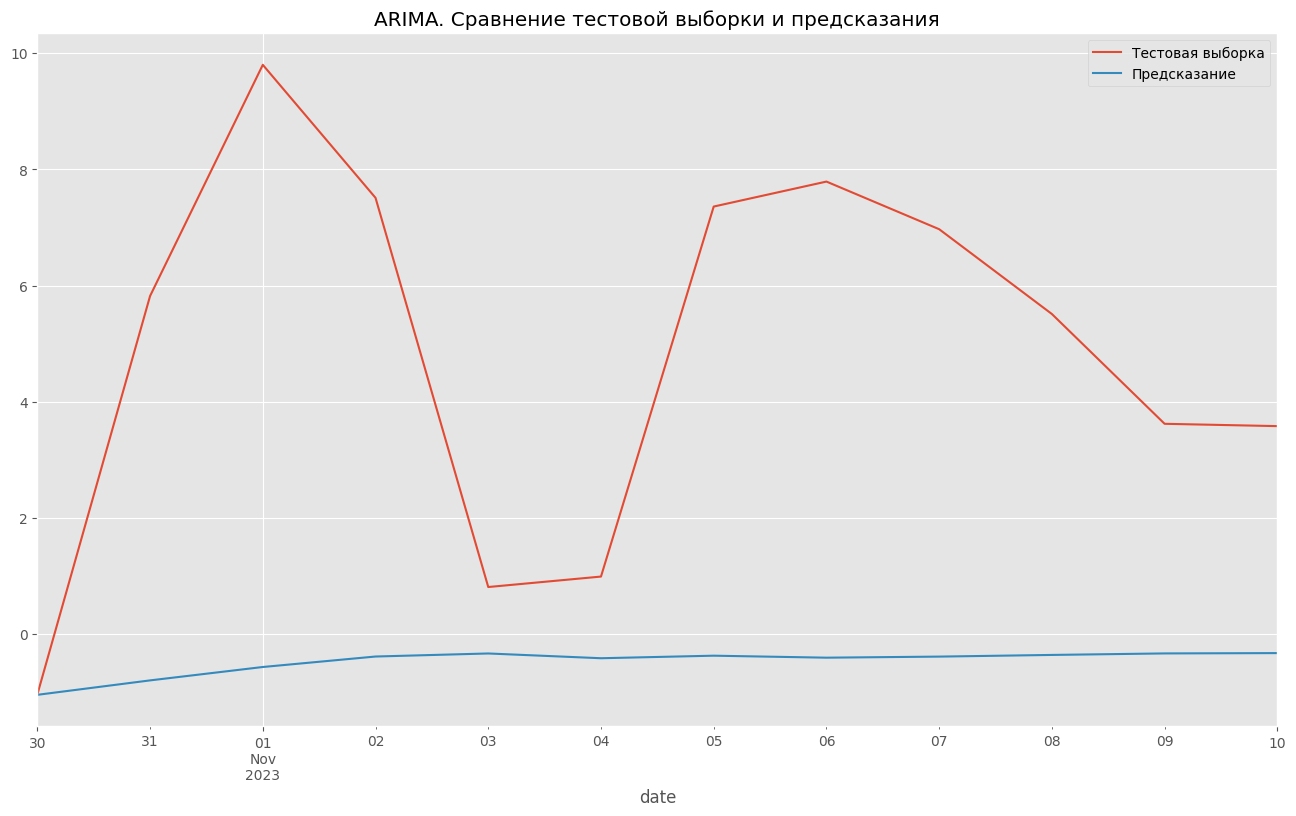

In [ ]:
test.plot(title='ARIMA. Сравнение тестовой выборки и предсказания')
st_prediction.plot(figsize=(16,9), legend=True).legend(['Тестовая выборка', 'Предсказание'])

In [ ]:
print(len(data))

17846


#Прогноз вперед на 90 дней

In [ ]:
s_prediction_future = SARIMAX(data, order=(4, 1, 4)).fit().predict(start=len(data)-10, end=len(data)+90)
s_prediction_future

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


2023-11-01    6.493938
2023-11-02    8.536640
2023-11-03    5.720792
2023-11-04   -0.252908
2023-11-05    1.947231
                ...   
2024-02-05    3.994413
2024-02-06    3.994413
2024-02-07    3.994413
2024-02-08    3.994413
2024-02-09    3.994413
Freq: D, Name: predicted_mean, Length: 101, dtype: float64

In [ ]:
s_prediction_future

2023-11-01    6.493938
2023-11-02    8.536640
2023-11-03    5.720792
2023-11-04   -0.252908
2023-11-05    1.947231
                ...   
2024-02-05    3.994413
2024-02-06    3.994413
2024-02-07    3.994413
2024-02-08    3.994413
2024-02-09    3.994413
Freq: D, Name: predicted_mean, Length: 101, dtype: float64

#Судя по графику, неважненький получился прогноз

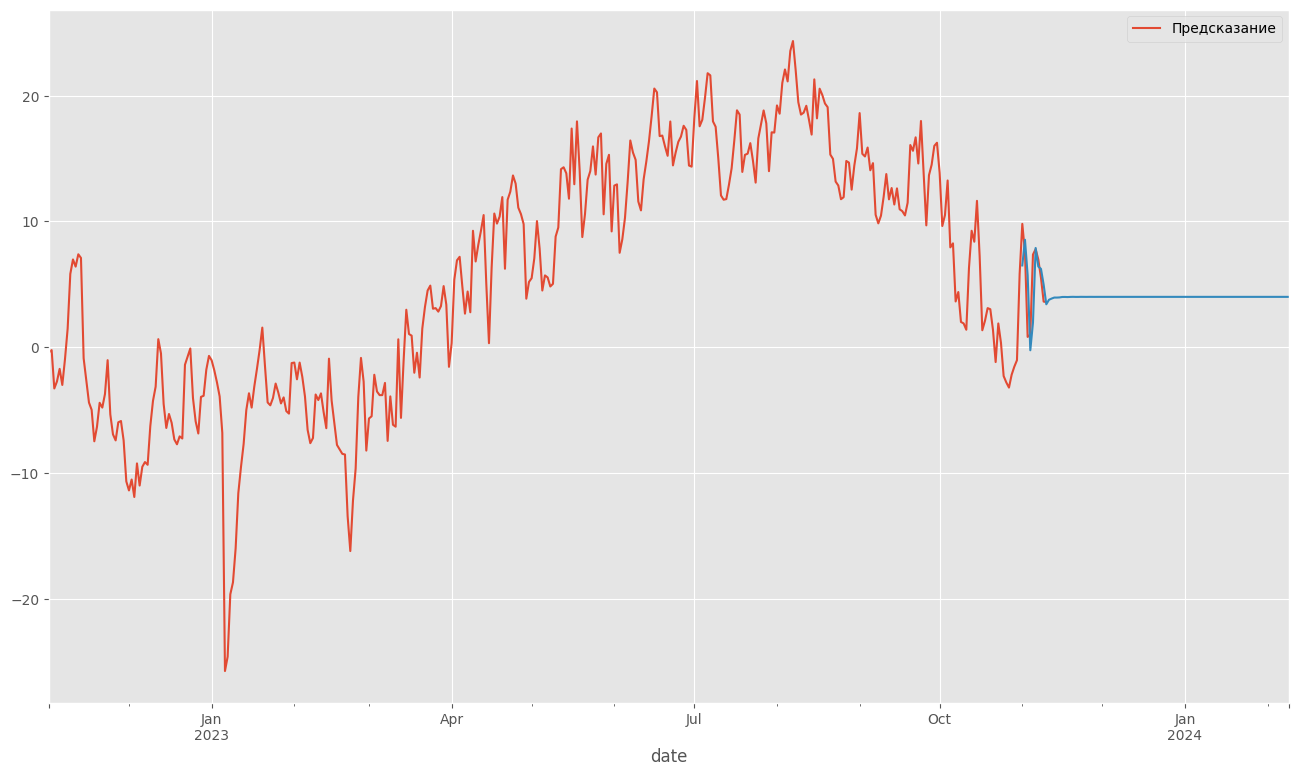

In [ ]:
data_filtered = data.loc['2022-11-01':]  # Отфильтруем датасет, оставив только данные начиная с 1 января 2023 года
ax = data_filtered.plot(legend=True,figsize=(16,9)).legend(['реальные данные'])  # Построим график
ax2 = s_prediction_future.plot(legend=True,figsize=(16,9)).legend(['Предсказание'])

#===============А теперь Prophet================

## Prophet

#Немного преобразуем датафрейм

In [ ]:
df_prophet = data.reset_index().copy()
df_prophet.columns = ['ds', 'y']
df_prophet.head()

,ds,y
0,2018-01-01,0.3
1,2018-01-02,1.4
2,2018-01-03,2.1
3,2018-01-04,1.4
4,2018-01-05,-1.3


#Делим на тренировочную и тестовую выборки

In [ ]:
train_prophet = df_prophet[:-90]
test_prophet = df_prophet[-90:]

In [ ]:
test_prophet

,ds,y
2050,2023-08-13,18.08
2051,2023-08-14,16.90
2052,2023-08-15,21.29
2053,2023-08-16,18.19
2054,2023-08-17,20.55
...,...,...
2135,2023-11-06,7.79
2136,2023-11-07,6.97
2137,2023-11-08,5.51
2138,2023-11-09,3.62


#Строим, обучаем модель, делаем прогноз

In [ ]:

model = Prophet(seasonality_mode='additive', )

model.fit(train_prophet)
future = model.make_future_dataframe(periods=150, freq='D')
forecast = model.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwjlyonlp/7lgg3kos.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwjlyonlp/twsocllo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84822', 'data', 'file=/tmp/tmpwjlyonlp/7lgg3kos.json', 'init=/tmp/tmpwjlyonlp/twsocllo.json', 'output', 'file=/tmp/tmpwjlyonlp/prophet_modelf1e6ol88/prophet_model-20231118173100.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:31:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:31:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


#Собственно - прогноз

In [ ]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01,5.787060,-10.778000,-0.539973,5.787060,5.787060,-11.499215,-11.499215,-11.499215,0.128472,0.128472,0.128472,-11.627687,-11.627687,-11.627687,0.0,0.0,0.0,-5.712155
1,2018-01-02,5.790060,-10.989243,-0.774555,5.790060,5.790060,-11.699427,-11.699427,-11.699427,0.080281,0.080281,0.080281,-11.779707,-11.779707,-11.779707,0.0,0.0,0.0,-5.909366
2,2018-01-03,5.793061,-11.405835,-1.051877,5.793061,5.793061,-12.074198,-12.074198,-12.074198,-0.147899,-0.147899,-0.147899,-11.926299,-11.926299,-11.926299,0.0,0.0,0.0,-6.281138
3,2018-01-04,5.796061,-11.080305,-1.085850,5.796061,5.796061,-12.106781,-12.106781,-12.106781,-0.042656,-0.042656,-0.042656,-12.064125,-12.064125,-12.064125,0.0,0.0,0.0,-6.310719
4,2018-01-05,5.799062,-11.617491,-0.951495,5.799062,5.799062,-12.183576,-12.183576,-12.183576,0.006495,0.006495,0.006495,-12.190071,-12.190071,-12.190071,0.0,0.0,0.0,-6.384514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,2024-01-05,5.039498,-12.511793,-1.585636,4.978075,5.101974,-12.122271,-12.122271,-12.122271,0.006495,0.006495,0.006495,-12.128766,-12.128766,-12.128766,0.0,0.0,0.0,-7.082774
2196,2024-01-06,5.039173,-12.587454,-2.052212,4.976960,5.102505,-12.291050,-12.291050,-12.291050,-0.043352,-0.043352,-0.043352,-12.247697,-12.247697,-12.247697,0.0,0.0,0.0,-7.251876
2197,2024-01-07,5.038849,-12.419004,-2.183624,4.975832,5.103234,-12.332018,-12.332018,-12.332018,0.018659,0.018659,0.018659,-12.350678,-12.350678,-12.350678,0.0,0.0,0.0,-7.293170
2198,2024-01-08,5.038524,-12.312493,-2.434074,4.974090,5.103657,-12.307021,-12.307021,-12.307021,0.128472,0.128472,0.128472,-12.435493,-12.435493,-12.435493,0.0,0.0,0.0,-7.268497


#Ой, как красивенько получилось!

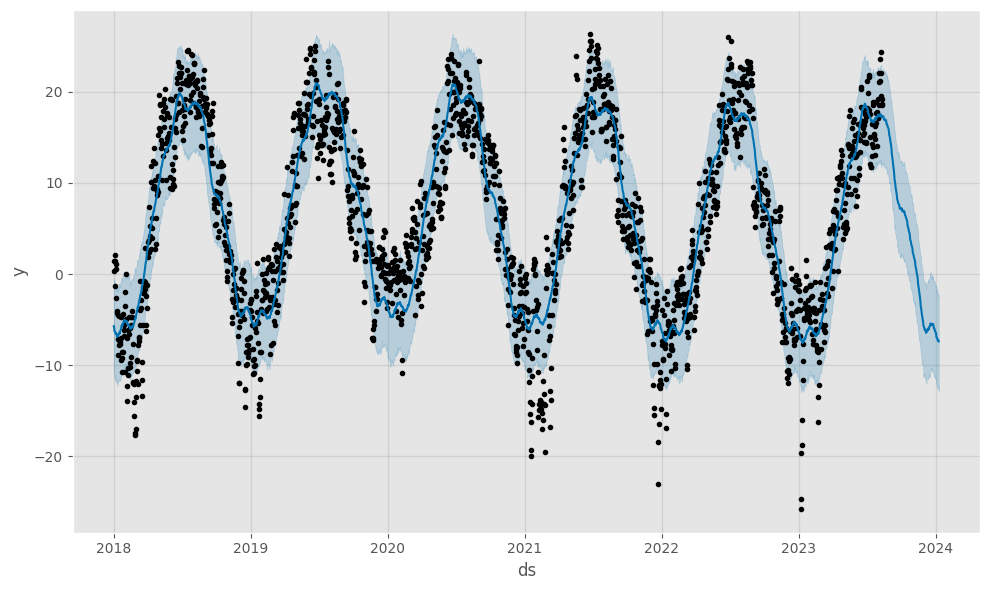

In [ ]:
ax = model.plot(forecast)

In [ ]:
forecast

#отфильтруем прогнозные значения с 10 октября 2023г.

In [ ]:
#data_filt = forecast.loc['2023-10-30':]
data_filt = forecast[forecast['ds'] >= '2023-10-30']

In [ ]:
data_filt

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2128,2023-10-30,5.061240,-2.076442,7.945921,5.041815,5.081843,-2.078226,-2.078226,-2.078226,0.128472,0.128472,0.128472,-2.206698,-2.206698,-2.206698,0.0,0.0,0.0,2.983014
2129,2023-10-31,5.060916,-2.285671,7.717889,5.040922,5.081983,-2.328345,-2.328345,-2.328345,0.080281,0.080281,0.080281,-2.408626,-2.408626,-2.408626,0.0,0.0,0.0,2.732570
2130,2023-11-01,5.060591,-2.936778,7.825816,5.040116,5.082465,-2.756623,-2.756623,-2.756623,-0.147899,-0.147899,-0.147899,-2.608724,-2.608724,-2.608724,0.0,0.0,0.0,2.303968
2131,2023-11-02,5.060267,-2.852309,7.451904,5.039080,5.082517,-2.850835,-2.850835,-2.850835,-0.042656,-0.042656,-0.042656,-2.808179,-2.808179,-2.808179,0.0,0.0,0.0,2.209432
2132,2023-11-03,5.059942,-3.107458,6.867408,5.038450,5.082605,-3.001904,-3.001904,-3.001904,0.006495,0.006495,0.006495,-3.008399,-3.008399,-3.008399,0.0,0.0,0.0,2.058038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,2024-01-05,5.039498,-12.511793,-1.585636,4.978075,5.101974,-12.122271,-12.122271,-12.122271,0.006495,0.006495,0.006495,-12.128766,-12.128766,-12.128766,0.0,0.0,0.0,-7.082774
2196,2024-01-06,5.039173,-12.587454,-2.052212,4.976960,5.102505,-12.291050,-12.291050,-12.291050,-0.043352,-0.043352,-0.043352,-12.247697,-12.247697,-12.247697,0.0,0.0,0.0,-7.251876
2197,2024-01-07,5.038849,-12.419004,-2.183624,4.975832,5.103234,-12.332018,-12.332018,-12.332018,0.018659,0.018659,0.018659,-12.350678,-12.350678,-12.350678,0.0,0.0,0.0,-7.293170
2198,2024-01-08,5.038524,-12.312493,-2.434074,4.974090,5.103657,-12.307021,-12.307021,-12.307021,0.128472,0.128472,0.128472,-12.435493,-12.435493,-12.435493,0.0,0.0,0.0,-7.268497


#Тестовая выборка

In [ ]:
p_prediction = test_prophet.set_index('ds').join(forecast.set_index('ds')[['yhat']][2023-10-30:])
p_prediction

,y,yhat
ds,,
2023-08-13,18.08,17.242594
2023-08-14,16.90,17.309186
2023-08-15,21.29,17.214787
2023-08-16,18.19,16.937068
2023-08-17,20.55,16.988858
...,...,...
2023-11-06,7.79,1.557540
2023-11-07,6.97,1.289221
2023-11-08,5.51,0.831855


#Метрики качества

In [ ]:
mse = MSE(p_prediction['y'], p_prediction['yhat'])
print('Prophet')
print('MAPE:', MAPE(p_prediction['y'], p_prediction['yhat']))
print('RMSE:', mse**.5)
print('MSE:', mse)

Prophet
MAPE: 0.8433235135973001
RMSE: 4.250882514257906
MSE: 18.070002150023615


#Графики тестовой выборки и предсказания

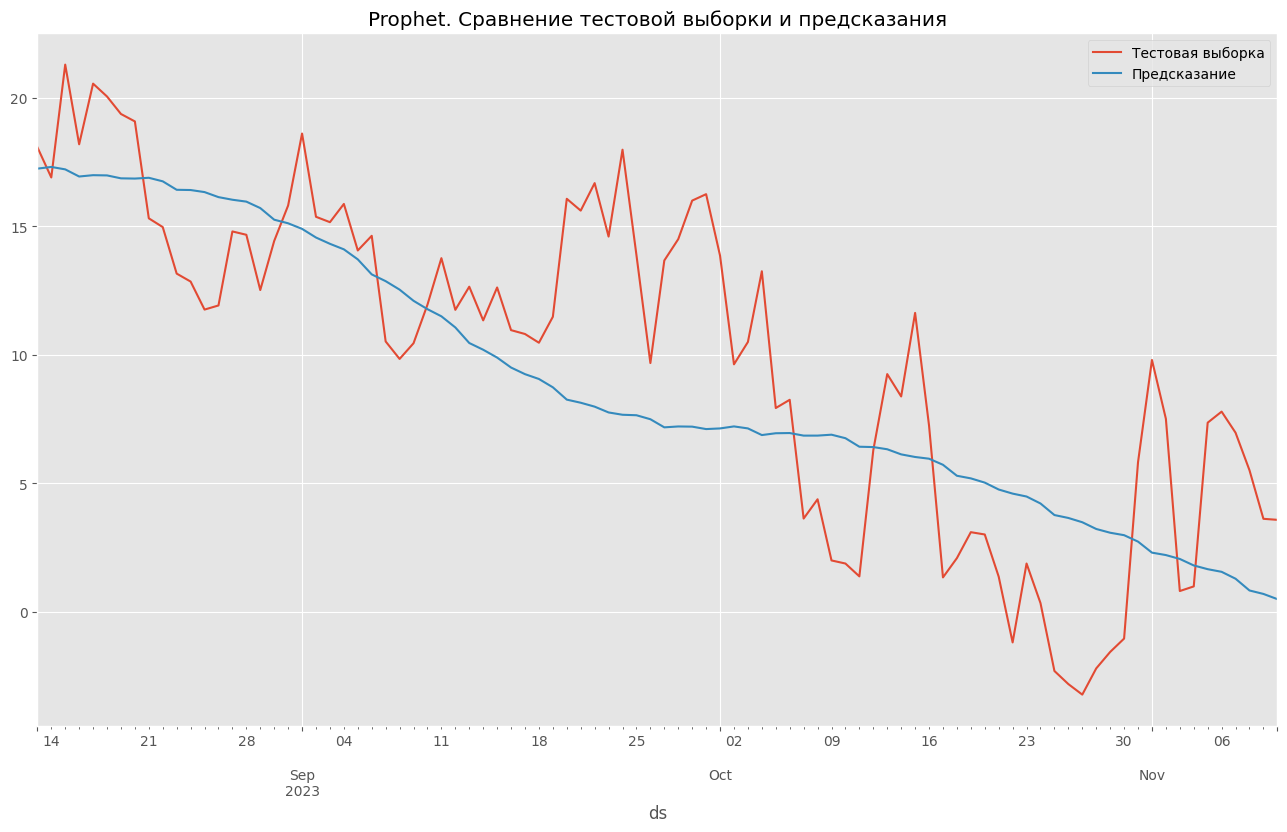

In [ ]:
ax1 = p_prediction['y'].plot(legend=True, title='Prophet. Сравнение тестовой выборки и предсказания')
ax2 = p_prediction['yhat'].plot(figsize=(16,9), legend=True) \
  .legend(['Тестовая выборка', 'Предсказание'])

#Найдем предсказанные значения температуры с 2018-01-01 по 2024-01-09

In [ ]:
prediction = forecast.set_index('ds')[['yhat']]
prediction[-90:]

,yhat
ds,
2023-10-12,6.410839
2023-10-13,6.325791
2023-10-14,6.126726
2023-10-15,6.025260
2023-10-16,5.958424
...,...
2024-01-05,-7.082774
2024-01-06,-7.251876
2024-01-07,-7.293170


In [ ]:
prediction

,yhat
ds,
2018-01-01,-5.712155
2018-01-02,-5.909366
2018-01-03,-6.281138
2018-01-04,-6.310719
2018-01-05,-6.384514
...,...
2024-01-05,-7.082774
2024-01-06,-7.251876
2024-01-07,-7.293170


In [ ]:
prediction1 = prediction.reset_index().copy()
prediction1.columns = ['date', 'y']

In [ ]:
prediction1

,date,y
0,2018-01-01,-5.712155
1,2018-01-02,-5.909366
2,2018-01-03,-6.281138
3,2018-01-04,-6.310719
4,2018-01-05,-6.384514
...,...,...
2195,2024-01-05,-7.082774
2196,2024-01-06,-7.251876
2197,2024-01-07,-7.293170
2198,2024-01-08,-7.268497


#Запишем предсказанные значения в CSV-файл

In [ ]:
# Сохранение изменений обратно в CSV-файл
prediction1.to_csv('prophet_predict.csv', index=False)

#График реальных данных начиная с 1 января 2023 года и прогноза за пределы датасета

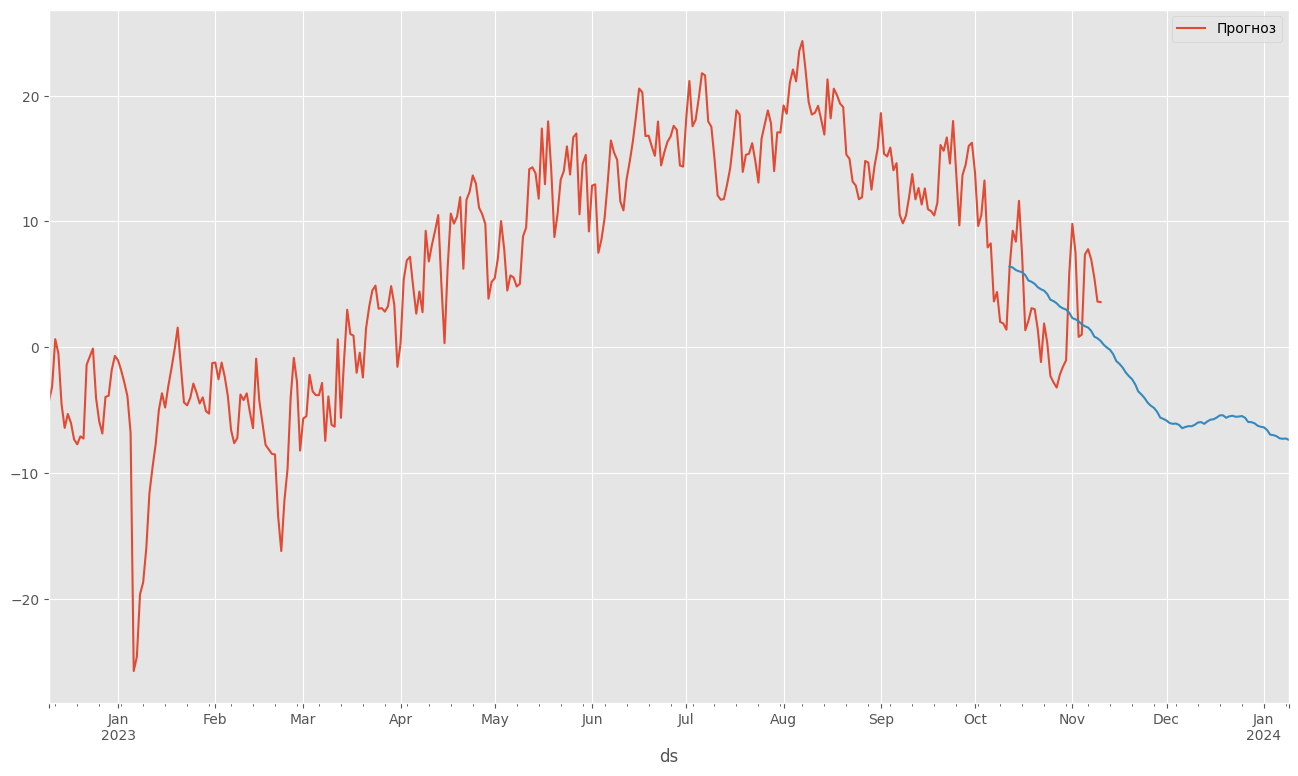

In [ ]:
data_filtered = data.loc['2022-12-10':]  # Отфильтруем датасет, оставив только данные начиная с 1 января 2023 года
ax = data_filtered.plot(legend=True,figsize=(16,9)).legend(['реальные данные'])  # Построим график
ax2 = prediction['yhat'][-90:].plot(figsize=(16,9)).legend(['Прогноз'])